# **Лабораторная работа №5**
## **Кластеризация**
## **Вариант 6: Клиенты магазина**

**Цель работы**: изучение принципов решения задачи многомерной регрессии с использованием методов машинного обучения на языке Python.

Набор данных содержит сведения о клиентах магазина, и к этим историческим данным необходимо применить сегментацию клиентов — процесс разбиения клиентской базы на группы с похожими характеристиками, что позволяет бизнесу более точно нацеливать маркетинговые усилия и распределять ресурсы; например, одна группа может включать клиентов с высоким доходом и высокой оценкой расходов, которых важно удерживать и стимулировать их лояльность, а другая — клиентов с меньшей активностью покупок, для которых целью является повышение вовлеченности через специальные предложения.

Набор данных включает следующие атрибуты:
*   Customer ID – идентификатор клиента.
*   Gender – пол клиента.
*   Age – возраст клиента в годах.
*   Annual Income – годовой доход клиента.
*   Spending Score – оценка расходов, присваиваемая магазином на основе поведения покупателя и характера расходов.
*   Work Experience – опыт работы в годах.
*   Family Size – размер семьи.





## Импортируем библиотеки и загружаем данные

In [78]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
df = pd.read_csv("Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


## Получим информацию о датасете

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              2000 non-null   int64 
 1   Gender                  2000 non-null   object
 2   Age                     2000 non-null   int64 
 3   Annual Income ($)       2000 non-null   int64 
 4   Spending Score (1-100)  2000 non-null   int64 
 5   Profession              1965 non-null   object
 6   Work Experience         2000 non-null   int64 
 7   Family Size             2000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 125.1+ KB


## Проверяем данные на наличие пропущенных значений и выбросов

In [80]:
# проверяем на пропущенные значения
print(df.isnull().sum())

CustomerID                 0
Gender                     0
Age                        0
Annual Income ($)          0
Spending Score (1-100)     0
Profession                35
Work Experience            0
Family Size                0
dtype: int64


## Заполняем пропуски

In [81]:
df_copy = df.copy()
# Заполняем пропуски в столбце Profession значением 'Unknown'
df_copy['Profession'] = df_copy['Profession'].fillna('Unknown')
df_copy['Profession'].isna().sum()


np.int64(0)

## Исключаем невлияющие категориальные признаки

In [82]:
if 'CustomerID' in df_copy.columns:
    df_copy.drop('CustomerID', axis=1, inplace=True)
if 'Gender' in df_copy.columns:
    df_copy = pd.get_dummies(df_copy, columns=['Gender', 'Profession'], drop_first=True)
df_copy.head()

,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size,Gender_Male,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Profession_Unknown
0,19,15000,39,1,4,True,False,False,False,False,True,False,False,False,False
1,21,35000,81,3,3,True,False,True,False,False,False,False,False,False,False
2,20,86000,6,1,1,False,False,True,False,False,False,False,False,False,False
3,23,59000,77,0,2,False,False,False,False,False,False,False,True,False,False
4,31,38000,40,2,6,False,False,False,True,False,False,False,False,False,False


## Применяем операцию нормализации для численной устойчивости

In [84]:
# импортируем класс для стандартизации данных
from sklearn.preprocessing import StandardScaler

# создадим объект класса StandardScaler
scaler  = StandardScaler()
scaler

StandardScaler()

## Приведем данные к единому масштабу

In [85]:
num_features = ['Age', 'Annual Income ($)', 'Spending Score (1-100)', 'Work Experience', 'Family Size']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_copy[num_features])
print(X[:4,:])

[[   19 15000    39     1     4]
 [   21 35000    81     3     3]
 [   20 86000     6     1     1]
 [   23 59000    77     0     2]]


## Определяем оптимальное количество кластеров с помощью метода локтя

In [86]:
from sklearn.cluster import KMeans

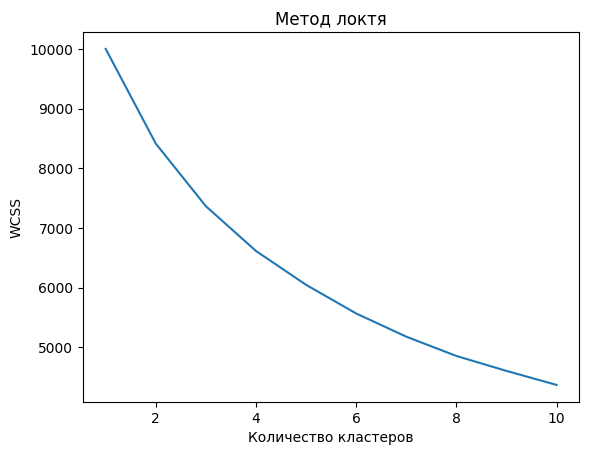

In [87]:
wcss = []
for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
  kmeans.fit(X_scaled)
  wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.show()

## Обучаем модель кластеризации

In [88]:
# создадим экземпляр модели
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
# обучаем модель на стандартизированных данных
kmeans.fit(X_scaled)


KMeans(n_clusters=5, random_state=42)

## Предсказываем кластеры и визуализируем результаты

In [89]:
# предсказываем кластеры для каждого
clusters = kmeans.predict(X_scaled)
# добавляем метки кластеров в исходные данные
df_copy['cluster'] = clusters
df_copy.head()

,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size,Gender_Male,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Profession_Unknown,cluster
0,19,15000,39,1,4,True,False,False,False,False,True,False,False,False,False,2
1,21,35000,81,3,3,True,False,True,False,False,False,False,False,False,False,3
2,20,86000,6,1,1,False,False,True,False,False,False,False,False,False,False,2
3,23,59000,77,0,2,False,False,False,False,False,False,False,True,False,False,3
4,31,38000,40,2,6,False,False,False,True,False,False,False,False,False,False,1


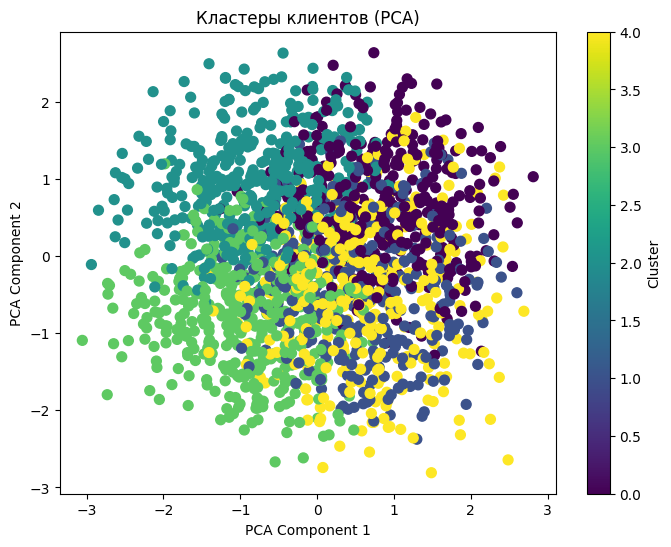

In [90]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=50)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Кластеры клиентов (PCA)')
plt.colorbar(label='Cluster')
plt.show()

In [91]:
# Группируем по кластерам
cluster_groups = df_copy.groupby('cluster')
# Анализ средних значений в каждом кластере
cluster_groups.mean()

,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size,Gender_Male,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Profession_Unknown
cluster,,,,,,,,,,,,,,,
0,77.772021,118707.772021,55.282383,4.056995,5.683938,0.406736,0.075130,0.108808,0.137306,0.075130,0.150259,0.031088,0.069948,0.028497,0.036269
1,23.207283,131385.333333,43.476190,3.235294,5.669468,0.375350,0.072829,0.086835,0.120448,0.084034,0.198880,0.030812,0.081232,0.042017,0.011204
2,57.164706,82542.743529,25.251765,2.522353,2.611765,0.392941,0.080000,0.096471,0.115294,0.063529,0.167059,0.018824,0.082353,0.049412,0.009412
3,40.356195,98593.161504,77.694690,1.911504,2.559735,0.402655,0.075221,0.075221,0.117257,0.077434,0.179204,0.019912,0.055310,0.042035,0.011062
4,44.944737,129192.378947,50.565789,9.336842,2.768421,0.457895,0.100000,0.081579,0.094737,0.084211,0.152632,0.052632,0.068421,0.050000,0.021053


## Визуализация по нескольким парам разных признаков с указанием центроидов

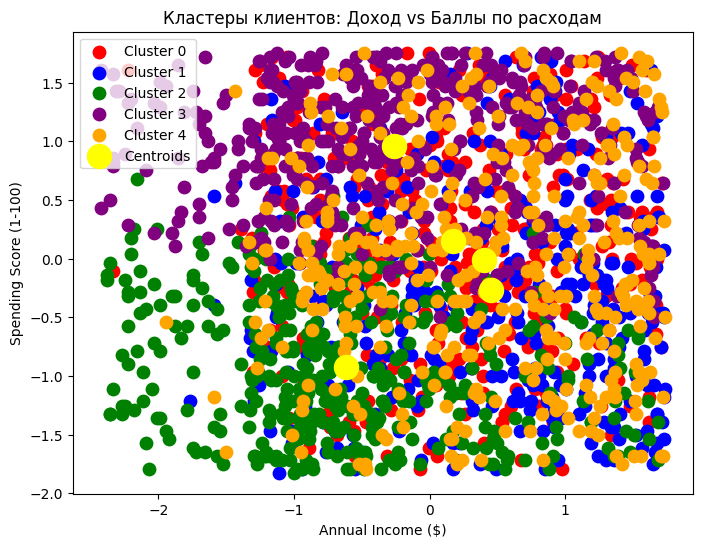

In [92]:
plt.figure(figsize=(8,6))
colors = ['red', 'blue', 'green', 'purple', 'orange']
for i in range(5):
    plt.scatter(X_scaled[clusters == i, 1], X_scaled[clusters == i, 2], s=80, c=colors[i], label=f'Cluster {i}')
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s=300, c='yellow', label='Centroids')
plt.xlabel('Annual Income ($)')
plt.ylabel('Spending Score (1-100)')
plt.title('Кластеры клиентов: Доход vs Баллы по расходам')
plt.legend()
plt.show()

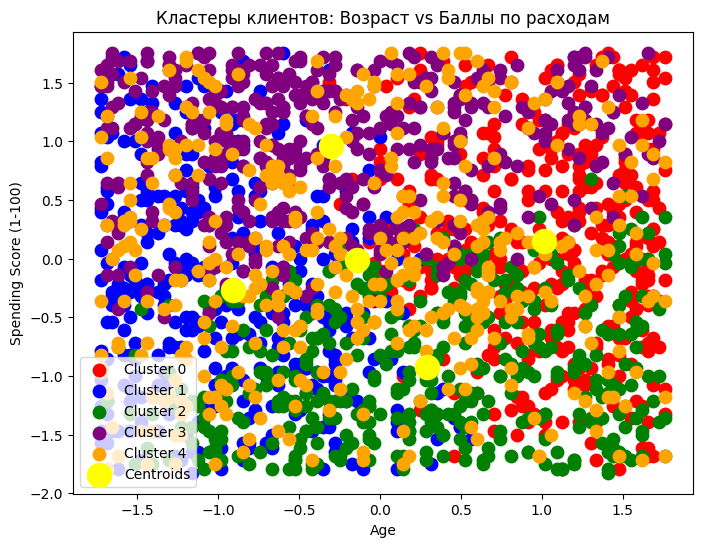

In [77]:
plt.figure(figsize=(8,6))
for i in range(5):
    plt.scatter(X_scaled[clusters == i, 0], X_scaled[clusters == i, 2], s=80, c=colors[i], label=f'Cluster {i}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 2], s=300, c='yellow', label='Centroids')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.title('Кластеры клиентов: Возраст vs Баллы по расходам')
plt.legend()
plt.show()

In [103]:
# Создаём колонку с уникальными айди клиентов
df_copy['CustomerID'] = ['C{:03d}'.format(i+1) for i in range(len(df_copy))]
df_copy.head()

,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size,Gender_Male,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Profession_Unknown,cluster,CustomerID
0,19,15000,39,1,4,True,False,False,False,False,True,False,False,False,False,2,C001
1,21,35000,81,3,3,True,False,True,False,False,False,False,False,False,False,3,C002
2,20,86000,6,1,1,False,False,True,False,False,False,False,False,False,False,2,C003
3,23,59000,77,0,2,False,False,False,False,False,False,False,True,False,False,3,C004
4,31,38000,40,2,6,False,False,False,True,False,False,False,False,False,False,1,C005


## Интерпретация результатов по кластерам
* 0: пожилые, крупные семьи, средние траты.
* 1: молодые, высокие доходы, большие семьи, умеренные траты.
* 2: зрелые, средний доход, экономные.
* 3: средний возраст, средний доход, активные траты.
* 4: большой опыт работы, высокий доход, средние траты.

In [104]:
# Выведем клиентов, относящихся к конкретному кластеру
n_clusters = df_copy['cluster'].nunique()  # определяем количество кластеров

for cluster_num in range(n_clusters):
    cluster_data = df_copy[df_copy['cluster'] == cluster_num]
    print(f"\nCluster {cluster_num} summary:")
    print(cluster_data[['Age', 'Annual Income ($)', 'Spending Score (1-100)',
                        'Work Experience', 'Family Size']].mean().round(1))
    print("Customer IDs:", cluster_data['CustomerID'].values)



Cluster 0 summary:
Age                           77.8
Annual Income ($)         118707.8
Spending Score (1-100)        55.3
Work Experience                4.1
Family Size                    5.7
dtype: float64
Customer IDs: ['C027' 'C060' 'C102' 'C119' 'C224' 'C228' 'C237' 'C244' 'C258' 'C311'
 'C323' 'C333' 'C342' 'C351' 'C369' 'C375' 'C397' 'C402' 'C405' 'C412'
 'C414' 'C416' 'C419' 'C422' 'C425' 'C432' 'C435' 'C438' 'C446' 'C452'
 'C454' 'C462' 'C463' 'C471' 'C472' 'C478' 'C485' 'C487' 'C500' 'C502'
 'C518' 'C524' 'C528' 'C534' 'C540' 'C546' 'C549' 'C552' 'C557' 'C561'
 'C566' 'C571' 'C573' 'C575' 'C580' 'C592' 'C593' 'C595' 'C598' 'C603'
 'C605' 'C611' 'C613' 'C616' 'C621' 'C623' 'C625' 'C626' 'C640' 'C642'
 'C644' 'C646' 'C648' 'C652' 'C658' 'C661' 'C662' 'C667' 'C668' 'C675'
 'C680' 'C682' 'C686' 'C700' 'C708' 'C711' 'C713' 'C724' 'C736' 'C746'
 'C750' 'C752' 'C756' 'C758' 'C760' 'C764' 'C774' 'C775' 'C780' 'C793'
 'C797' 'C802' 'C809' 'C810' 'C811' 'C813' 'C816' 'C818' 'C821' 'C